In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
print("pytorch ver . ",torch.__version__)
print("Is CUDA available?",torch.cuda.is_available())
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.utils.data as Data
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import math

/home/luhung3080/miniconda3/envs/chou/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pytorch ver .  1.11.0+cu113
Is CUDA available? True


# Read data

In [2]:
data=pd.read_csv('/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/data_final.csv')

# Generate X Y 

In [3]:
x1=np.zeros([604,1704])
x2=np.zeros([604,5112])

#x1 (0th~1703th column as x)
for i in range (0,604):
    for j in range (0,71):
        a=np.array(data['pm25_obs'][5112*i+72*j:5112*i+72*j+24])
        for k in range (0,24):
            x1[i][j*24+k]=a[k]

#x2 (1704th~8519th column as x)
for i in range (1,604):
    b=np.array(data['pm25_cal'][5112*i:5112*i+5112])
    for j in range(0,5112):
        x2[i-1][j]=b[j]
        
print(np.shape(x1))
print(np.shape(x2))

(604, 1704)
(604, 5112)


In [4]:
x1Restruct_Fun=x1
x2Restruct_Fun=x2
print(np.shape(x1Restruct_Fun))
print(np.shape(x2Restruct_Fun))

(604, 1704)
(604, 5112)


In [5]:
YRestruct_Fun=np.zeros([601,5112])
for j in range (0,71):
    for i in range(0,601):
        YRestruct_Fun[i][72*j:72*j+24]=x1Restruct_Fun[1+i][24*j:24*j+24]
        YRestruct_Fun[i][72*j+24:72*j+48]=x1Restruct_Fun[1+i+1][24*j:24*j+24]
        YRestruct_Fun[i][72*j+48:72*j+72]=x1Restruct_Fun[1+i+2][24*j:24*j+24]
print(np.shape(YRestruct_Fun))

(601, 5112)


In [6]:
XRestruct_Fun=np.zeros([601,6816])
for i in range (0,601):
    for j in range (0,1704):
        XRestruct_Fun[i][j]=x1Restruct_Fun[i][j]
    for j in range (1704,6816):
        XRestruct_Fun[i][j]=x2Restruct_Fun[i][j-1704]
print(np.shape(XRestruct_Fun))

(601, 6816)


In [8]:
Xhat=XRestruct_Fun
Yhat=YRestruct_Fun
Xhat_train = np.zeros([540,6816])
Yhat_train = np.zeros([540,5112])
Xhat_test = np.zeros([61,6816])
Yhat_test = np.zeros([61,5112])
for i in range (0,540):
    for j in range (0,6816):
        Xhat_train[i][j] = Xhat[i][j]
    for j in range (0,5112):
        Yhat_train[i][j] = Yhat[i][j]
for i in range (540,601):
    for j in range (0,6816):
        Xhat_test[i-544][j] = Xhat[i][j]
    for j in range (0,5112):     
        Yhat_test[i-544][j] = Yhat[i][j]
    
print('Xhat_train')
#print(Xhat_train)
print(np.shape(Xhat_train))
print('Yhat_train')
#print(Yhat_train)
print(np.shape(Yhat_train))
print('Xhat_test')
#print(Xhat_test)
print(np.shape(Xhat_test))
print('Yhat_test')
#print(Yhat_test)
print(np.shape(Yhat_test))

Xhat_train
(540, 6816)
Yhat_train
(540, 5112)
Xhat_test
(61, 6816)
Yhat_test
(61, 5112)


In [9]:
Xhat_train_n = np.zeros([71,540,96])
Yhat_train_n = np.zeros([71,540,72])
Xhat_test_n = np.zeros([71,61,96])
Yhat_test_n = np.zeros([71,61,72])
for i in range (0,71):
    for j in range (0,540):
        for k in range (0,24):
            Xhat_train_n[i][j][k] = Xhat_train[j][24*i+k]
        for k in range (0,72):
            Xhat_train_n[i][j][k+24] = Xhat_train[j][1704+(72*i)+k]
            Yhat_train_n[i][j][k] = Yhat_train[j][(72*i)+k]
    for j in range (0,61):
        for k in range (0,24):
            Xhat_test_n[i][j][k] = Xhat_test[j][24*i+k]
        for k in range (0,72):
            Xhat_test_n[i][j][k+24] = Xhat_test[j][1704+(72*i)+k]
            Yhat_test_n[i][j][k] = Yhat_test[j][(72*i)+k]
print('Xhat_train')
print(np.shape(Xhat_train_n))
print('Yhat_train')
print(np.shape(Yhat_train_n))
print('Xhat_test')
print(np.shape(Xhat_test_n))
print('Yhat_test')
print(np.shape(Yhat_test_n))
Xhat_val=Xhat_test_n
Yhat_val=Yhat_test_n
print('Xhat_val')
print(np.shape(Xhat_val))
print('Yhat_val')
print(np.shape(Yhat_val))

Xhat_train
(71, 540, 96)
Yhat_train
(71, 540, 72)
Xhat_test
(71, 61, 96)
Yhat_test
(71, 61, 72)
Xhat_val
(71, 61, 96)
Yhat_val
(71, 61, 72)


# Modeling

In [10]:
class PytorchLightningModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv1d(1 , 32 , 2)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Conv1d(32 , 32 , 2)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Conv1d(32, 32 , 2)
        self.act3 = nn.ReLU()
        self.layer4 = nn.Conv1d(32 , 32 , 2)
        self.act4 = nn.ReLU()
        self.layer5 = nn.Conv1d(32 , 32 , 2)
        self.act5 = nn.ReLU()
        self.fl = nn.Flatten()
        self.fc1 = nn.Linear(91*32,264)
        self.fc2 = nn.Linear(264,72)
    
    def forward(self, x): 
        ouput = torch.unsqueeze(x,1)
        ouput = self.act1(self.layer1(ouput))
        ouput = self.act2(self.layer2(ouput))
        ouput = self.act3(self.layer3(ouput))
        ouput = self.act4(self.layer4(ouput))
        ouput = self.act5(self.layer5(ouput))
        ouput = self.fl(ouput)
        ouput = self.fc1(ouput)
        ouput = self.fc2(ouput)
        return ouput

    def configure_optimizers(self): 
        return optim.Adam(self.parameters(), lr=1e-4) 

    def prepare_data(self): 
        self.train_set = Data.TensorDataset(x_train , y_train) 
        self.test_set = Data.TensorDataset(x_test, y_test)
        self.val_set = Data.TensorDataset(x_val, y_val)

    def train_dataloader(self):
        return Data.DataLoader(dataset=self.train_set , batch_size=540 , shuffle=True)

    def test_dataloader(self):
        return Data.DataLoader(dataset=self.test_set , batch_size=61 , shuffle=False)

    def val_dataloader(self):
        return Data.DataLoader(dataset=self.val_set , batch_size=61 , shuffle=False)

    def training_step(self, batch, batch_idx): 
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss}
        self.log("train_loss_MAE", loss)
        return {'loss' : loss , 'log' : logs}

    def test_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss}
        self.log("test_loss_MAE", loss)
        return {'loss' : loss , 'log' : logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch 
        output  = self.forward(x)
        loss = nn.L1Loss(reduction='mean')(output, y)
        logs = {'loss' : loss}
        self.log("val_loss_MAE", loss)
        return {'loss' : loss , 'log' : logs}

# Loop for 71 stations

In [ ]:
for i in range (0,71):
    x_train = torch.from_numpy(Xhat_train_n[i]).float()
    y_train = torch.from_numpy(Yhat_train_n[i]).float()
    x_test = torch.from_numpy(Xhat_test_n[i]).float()
    y_test = torch.from_numpy(Yhat_test_n[i]).float()
    x_val = torch.from_numpy(Xhat_val[i]).float()
    y_val = torch.from_numpy(Yhat_val[i]).float()
    
    logger = CSVLogger("jupyterNB_logs", name="CNN_csv_v1")
    model = PytorchLightningModel() 
    trainer = pl.Trainer(max_epochs=500 , gpus=1 , logger=logger)
    trainer.fit(model)
    trainer.test(model)

# Result

In [12]:
#lr=1e-4,epoch=500
score = np.zeros(71)
for i in range (0,71):
    df = pd.read_csv("/home/luhung3080/Desktop/PycharmProjects/NCHUproject/Transformer/jupyterNB_logs/CNN_csv_v1/version_"+str(i)+"/metrics.csv")
    s=np.array(df['val_loss_MAE'].fillna(100))
    score[i]=np.min(s)

print(np.nanmean(score))

4.7627277273527335


In [13]:
print(score)

[3.34061217 3.4486599  3.78842521 3.27532935 4.00163937 3.81313634
 3.93903732 3.48496914 4.06133652 3.61092687 3.71243334 3.61656713
 3.42500019 3.46931434 3.51016092 4.06329012 4.25339985 4.6520915
 4.38546085 4.57442999 4.66109943 4.5854454  4.64169788 6.00946856
 5.4393115  5.76197863 6.46652699 5.68004942 6.26399422 5.69224119
 6.05440378 6.34576368 6.1314311  7.62031174 5.79042292 6.19099522
 6.42625618 6.1303792  5.84840059 5.24946165 5.6329689  5.30012465
 5.32761097 5.62319136 5.20255804 4.50550461 5.54117632 5.2668519
 5.12625837 6.56510258 5.49277925 5.39027309 5.12187386 5.54646397
 5.68598652 5.20824528 5.25257587 5.06107473 2.67968297 2.50715351
 2.50711465 3.18745637 2.84545517 2.90373468 3.8507483  4.20548582
 5.78634834 3.19936705 5.84815407 5.97884893 2.38763881]


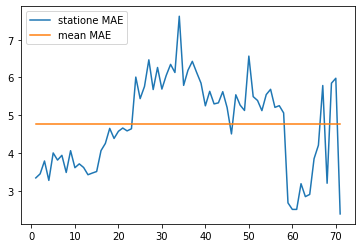

In [14]:
m = np.nanmean(score)*np.ones(71)
fig1 = plt.figure(1)
x=np.linspace(1,71,71)
plt.plot(x,score, label = 'statione MAE')
plt.plot(x,m, label = 'mean MAE')
plt.legend(loc = 2)

plt.show()

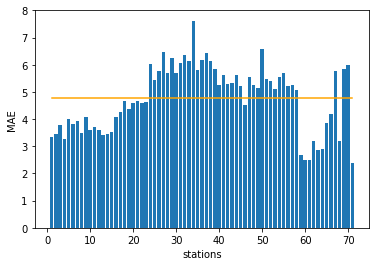

In [15]:
m = np.nanmean(score)*np.ones(71)
fig1 = plt.figure(1)
plt.bar(x,score,width=0.8)
plt.xlabel('stations')
plt.ylabel('MAE')
plt.plot(x,m, color='Orange')

plt.show()